In [22]:
import numpy as np
from matplotlib import pyplot as plt
from tct import tct

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## Import with custom python code

In [49]:
metadata, data = tct.read("test_dec_focus5.rtct")

## Manage data with pandas
Can handle easily sparse data

In [50]:
def remove_singular_levels(df):
    to_be_removed = []
    for i in range(df.index.nlevels):
        if len(df.index.levels[i]) == 1:
            to_be_removed.append(df.index.names[i])
    for iname in to_be_removed:
        n = df.index.names.index(iname)
        df.index = df.index.droplevel(n)
    return df

In [51]:
import pandas as pd
import seaborn as sns

df = pd.Series(list(data['ch1']), index=[data['x'], data['y'], data['z']])
df.index.names = 'x', 'y', 'z'
df = df.sort_index()
df = remove_singular_levels(df)

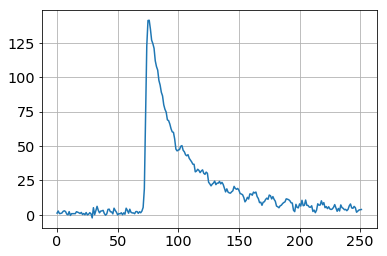

In [52]:
plt.plot(df.iloc[100])
plt.grid()

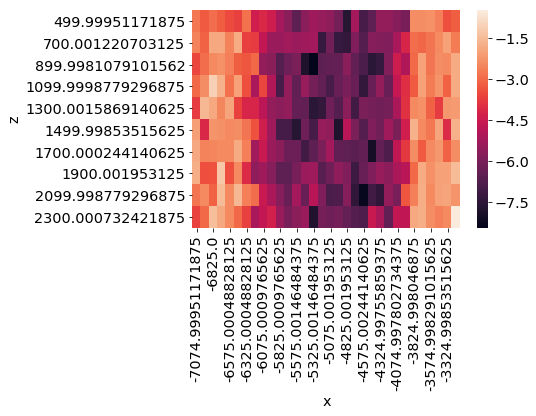

In [42]:
sns.heatmap(df.apply(np.min).unstack().T)

## Manage data with xarray
Can manage only rectangular data (only grid scan, no sparse scan)

In [54]:
import xarray

In [55]:
ds = xarray.DataArray(data['ch1'].reshape(metadata['nz'], metadata['ny'], metadata['nx'], metadata['NP']),
                      coords=[np.unique(np.sort(data['z'])),
                              np.unique(np.sort(data['y'])),
                              np.unique(np.sort(data['x'])),                              
                              np.arange(0, metadata['NP'] * metadata['dt'], metadata['dt']) / 1E-9], dims=['z', 'y', 'x', 'NP'])
ds.coords['NP'].attrs['unit'] = 'ns'

In [56]:
ds.coords

Coordinates:
  * z        (z) float32 -1000.5011 -870.4995 -740.49786 ... 2769.0 2899.0017
  * y        (y) float32 -642.5006
  * x        (x) float32 -7074.9995 -6950.0 -6825.0 ... -3324.9985 -3199.9988
  * NP       (NP) float64 0.0 0.4 0.8 1.2 1.6 2.0 ... 98.8 99.2 99.6 100.0 100.4

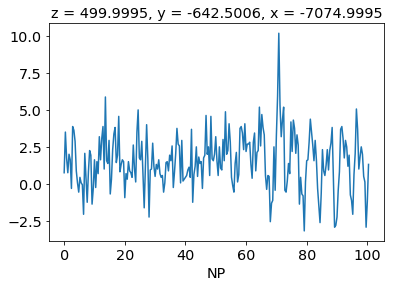

In [46]:
ds.isel(x=0, y=0, z=0).plot()

## Geometrical model for the focusing

The laser spot moves along $x$-direction, which is not perfectly perpendicular to the sensor edge. Its direction deviate to the perpendicular to the surface by $\theta$. Its distance to the surface is $d = x\cos\theta$. The fraction of the area of the circular spot which is illuminating the sensor is:

$$
  \frac{1}{\pi R^2}\int_{\text{circle and } x > d} dx dy = \frac{2}{\pi R^2} \int_{-R}^d \sqrt{R^2 - x^2} dx = \frac{1}{\pi R^2}\left[d \sqrt{R^2 - d^2} + R^2 \arctan\left(\frac{d}{\sqrt{R^2-d^2}}\right) + \pi/2 R^2\right]
$$

if there distance is $<-R$ (fully outside the sensor) it is 0, if $>R$ (fully inside the sensor) it is 1.

In [47]:
def area_fraction(R, distance):
    distance = np.clip(distance, -R, R)
    sq = np.sqrt(R ** 2 - distance ** 2)
    area = distance * sq + R ** 2 * np.arctan(distance / sq) + np.pi / 2. * R ** 2
    return area / (np.pi * R ** 2)

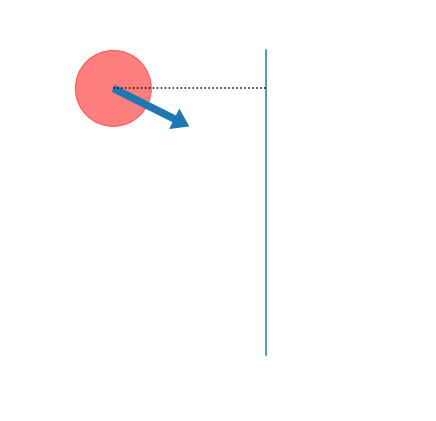

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.add_patch(plt.Circle((0.2, 0.8), 0.1, color='r', alpha=0.5))
ax.add_line(plt.Line2D((0.6, 0.6), (0.1, 0.9)))
ax.add_line(plt.Line2D((0.2, 0.6), (0.8, 0.8), color='k', ls=':'))
ax.add_patch(plt.Arrow(0.2, 0.8, 0.2, -0.1, width=0.1))
ax.set_aspect('equal')
ax.axis('off')

plt.show()

/home/turra/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


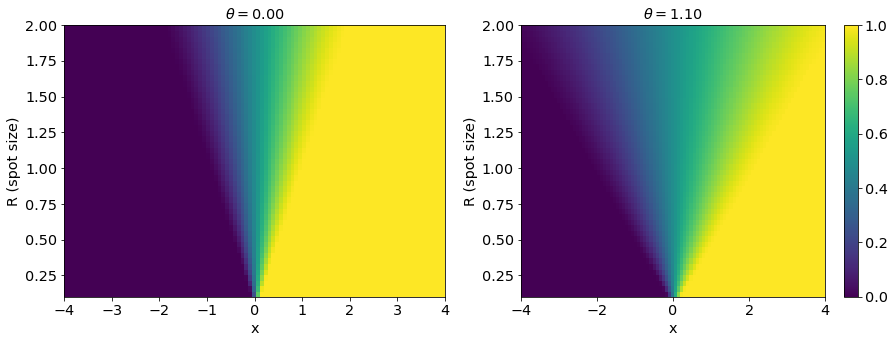

In [13]:
r = np.linspace(0.1, 2, 50)
x = np.linspace(-4, 4, 100)
xx, rr = np.meshgrid(x, r)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

theta = 0
axs[0].set_title(r'$\theta = %.2f$' % theta)
dd = xx * np.cos(theta)
axs[0].pcolormesh(x, r, area_fraction(rr, dd))

theta = 1.1
axs[1].set_title(r'$\theta = %.2f$' % theta)
dd = xx * np.cos(theta)
cs = axs[1].pcolormesh(x, r, area_fraction(rr, dd))

fig.colorbar(cs)


for ax in axs:
    ax.set_xlabel('x')
    ax.set_ylabel('R (spot size)')

If we suppose the optic to be a simple: parallel ray on a thin converging lens with aperture (diameter) $A$ and focus distance $f$, then the image should be a circle with a diameter equal to

$$
R = A \frac{|z-f|}{f}
$$

where $z$ is the distance from the lens to the plane. There is an absolute value since we are not sensitive to the inversion of the image.

Text(0, 0.5, 'R (spot size)')

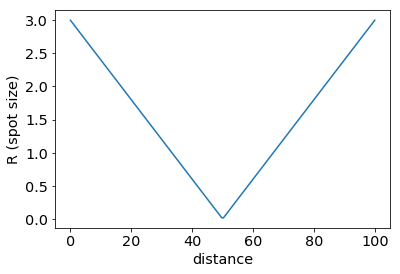

In [14]:
z = np.linspace(0, 100, 200)
f = 50
aperture = 3
r = np.abs(aperture / f * (z - f))
plt.plot(z, r)
plt.xlabel('distance')
plt.ylabel('R (spot size)')

/home/turra/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


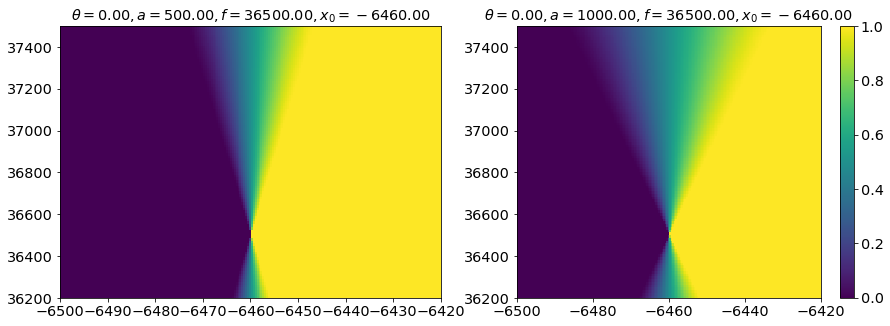

In [15]:
z = np.linspace(36200, 37500, 100)
x = np.linspace(-6500, -6420, 200)
xx, zz = np.meshgrid(x, z)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

aperture = 500
theta = 0
focus = 36500
x0 = -6460

axs[0].set_title(r'$\theta = %.2f, a = %.2f, f = %.2f, x_0 = %.2f$' % (theta, aperture, focus, x0))
dd = (xx - x0) * np.cos(theta)
rr = np.abs(aperture / focus * (zz - focus))
axs[0].pcolormesh(x, z, area_fraction(rr, dd))


aperture = 1000
theta = 0.
focus = 36500.
x0 = -6460

axs[1].set_title(r'$\theta = %.2f, a = %.2f, f = %.2f, x_0 = %.2f$' % (theta, aperture, focus, x0))
dd = (xx - x0) * np.cos(theta)
rr = np.abs(aperture / focus * (zz - focus))
cs = axs[1].pcolormesh(x, z, area_fraction(rr, dd))
fig.colorbar(cs)


/home/turra/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


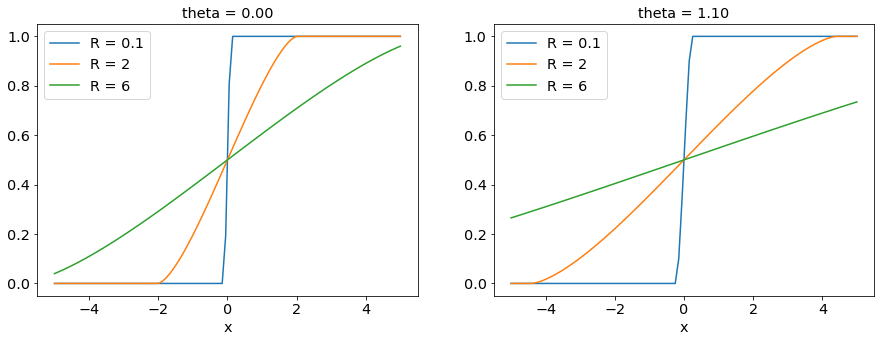

In [16]:
xx = np.linspace(-5, 5, 100)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

theta = 0.0
d = xx * np.cos(theta)
axs[0].set_title('theta = %.2f' % theta)
axs[0].plot(xx, area_fraction(0.1, d), label='R = 0.1')
axs[0].plot(xx, area_fraction(2, d), label='R = 2')
axs[0].plot(xx, area_fraction(6, d), label='R = 6')
axs[0].legend()

theta = 1.1
d = xx * np.cos(theta)
axs[1].set_title('theta = %.2f' % theta)
axs[1].plot(xx, area_fraction(0.1, d), label='R = 0.1')
axs[1].plot(xx, area_fraction(2, d), label='R = 2')
axs[1].plot(xx, area_fraction(6, d), label='R = 6')
axs[1].legend()

for ax in axs:
    ax.set_xlabel('x')

## Data
Plotting the minimum of the signal (the shapes are negative, so a large negative value means inside the sensor)

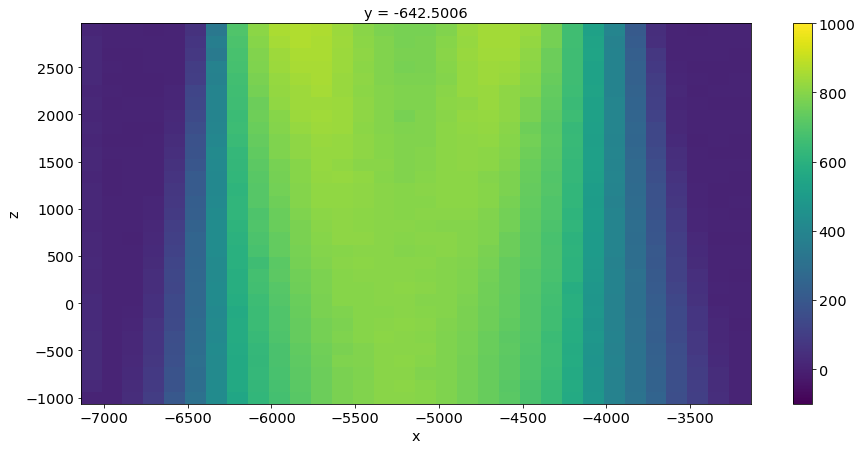

In [57]:
fig, ax = plt.subplots(figsize=(15, 7))
ds.max(dim='NP').plot(robust=True, vmin=-100, vmax=1000, ax=ax)
#fig.savefig('focus.png')

Plot signal shape inside well inside the sensor

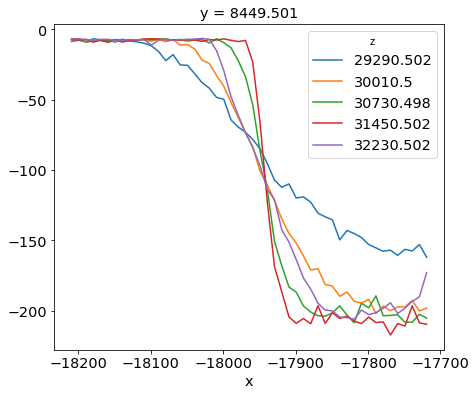

In [18]:
fig, ax = plt.subplots(figsize=(7, 6))
ds[np.linspace(0, ds['z'].size - 1, 5, dtype=int)].min('NP').squeeze().plot.line(x='x', hue='z', ax=ax)
fig.savefig('steps.pdf')

Plotting differences along x (to find the focus just with a maximum)

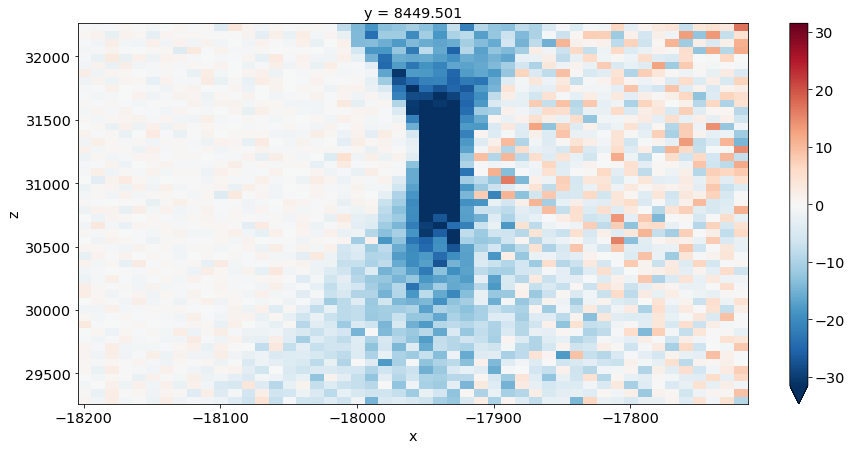

In [19]:
fig, ax = plt.subplots(figsize=(15, 7))
ds.min(dim='NP').diff(dim='x').plot(robust=True, ax=ax)
fig.savefig('diffs_old.png')

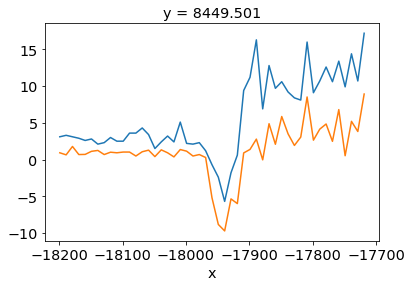

In [20]:
ds.min(dim='NP').diff(dim='x').max(dim='z').plot()
ds.min(dim='NP').diff(dim='x').rolling(z=5, center=True).mean().max(dim='z').plot()

31210.5


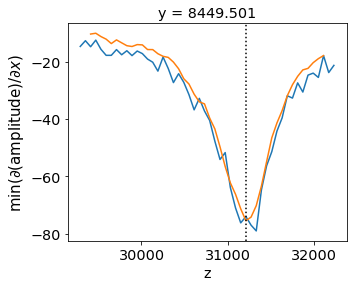

In [24]:
fig, ax = plt.subplots(figsize=(5, 4))
ds.min(dim='NP').diff(dim='x').min(dim='x').plot(ax=ax)
ds.min(dim='NP').diff(dim='x').rolling(z=5, center=True).mean().min(dim='x').plot(ax=ax)

izmax = ds.min(dim='NP').diff(dim='x').rolling(z=5, center=True).mean().min(dim='x').argmin().item()
zmax = ds.z[izmax].item()
ax.axvline(zmax, ls=':', color='k')
ax.set_ylabel(r'$\min\left( \partial (\mathrm{amplitude})/\partial x\right)$', fontsize=15)
fig.savefig('peak.pdf', bbox_inches='tight')
print(zmax)

19.998046875


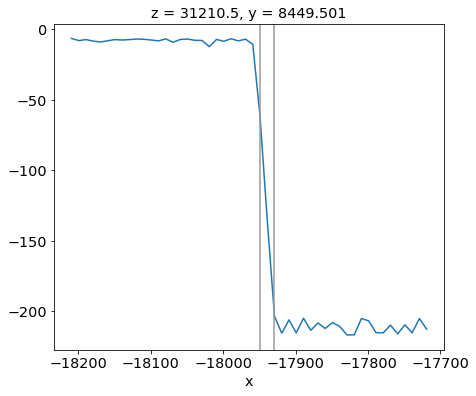

In [22]:
fig, ax = plt.subplots(figsize=(7, 6))
xbest = ds.isel(z=izmax).min('NP')
xbest.plot(x='x')
m, M = np.min(xbest).item(), np.max(xbest).item()
delta = np.abs(M - m)
m = m + delta * 0.1
M = M - delta * 0.1


left = xbest.x[np.argmax(xbest < M)].item()
right = xbest.x[np.argmax(xbest < m)].item()

ax.axvline(left, color="0.6")
ax.axvline(right, color="0.6")
print(right - left)

Showing non-focused and focused configuration

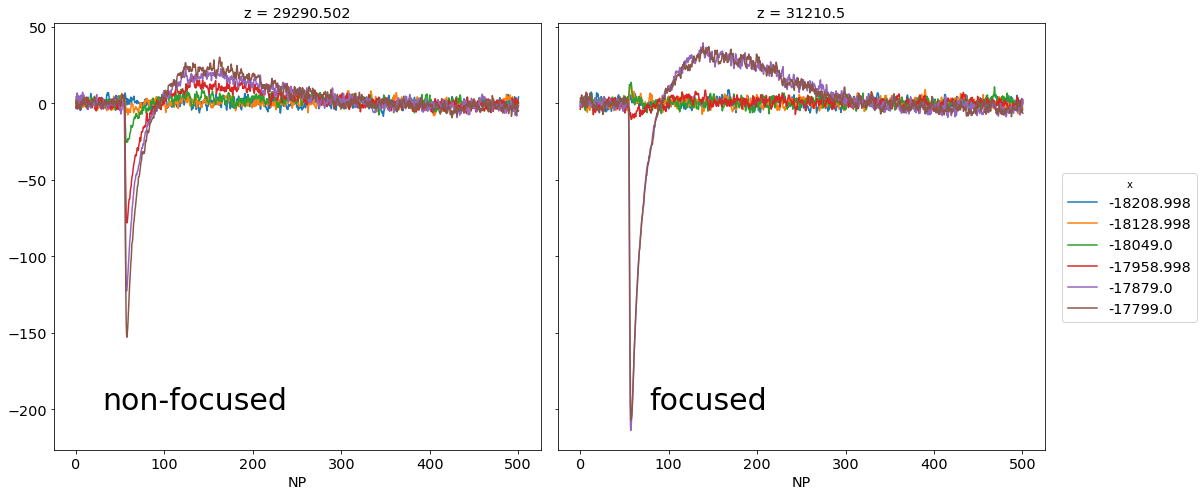

In [23]:
fig = ds.isel(dict(x=np.linspace(0, ds.x.size, 6, dtype=int, endpoint=False), y=0, z=[0, izmax])).plot(x='NP', hue='x', col='z', figsize=(15, 7))
fig.axes[0][0].text(0.1, 0.1, 'non-focused', transform=ax.transAxes, fontsize=30)
fig.axes[0][1].text(1.5, 0.1, 'focused', transform=ax.transAxes, fontsize=30)

fig.fig.savefig('focusing_example.pdf')